### TP 5 : Market Impact

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

Bibliography:
Eisler, Z., Bouchaud, J.-P., & Kockelkoren, J. (2018). The price impact of order book events: market orders, limit orders and cancellations. Capital Fund Management. Retrieved from http://arxiv.org/abs/0904.0900v3

In [1]:
import numpy
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
from tqdm import tqdm
import Hawkes as hwk

In [2]:
## Load data from SG and BNPP

# Step 1: Load all files in the directory
data_path = "Data/"
SG_file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]

BNPP_file_list = [
    "BNPP_20170117.csv.gz",
    "BNPP_20170118.csv.gz",
    "BNPP_20170119.csv.gz",
    "BNPP_20170120.csv.gz",
    "BNPP_20170123.csv.gz",
    "BNPP_20170124.csv.gz",
    "BNPP_20170125.csv.gz",
    "BNPP_20170126.csv.gz",
    "BNPP_20170127.csv.gz",
    "BNPP_20170130.csv.gz",
    "BNPP_20170131.csv.gz",
    "BNPP_20170201.csv.gz",
]
# Create a list to store each DataFrame
df_list = []
for file in SG_file_list:
    df = pd.read_csv(data_path + "SG/" + file, compression='gzip')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list.append(df)

# Concatenate all DataFrames into one
SG_df = pd.concat(df_list, ignore_index=True)

df_list = []
for file in BNPP_file_list:
    df = pd.read_csv(data_path + "BNPP/" + file, compression='gzip')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list.append(df)

# Concatenate all DataFrames into one
BNPP_df = pd.concat(df_list, ignore_index=True)

In [3]:
SG_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7827010 entries, 0 to 7827009
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ets     datetime64[ns]
 1   etype   object        
 2   eprice  int64         
 3   eqty    int64         
 4   eside   object        
 5   bp0     int64         
 6   bq0     int64         
 7   ap0     int64         
 8   aq0     int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 537.4+ MB


In [4]:
BNPP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5423830 entries, 0 to 5423829
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ets     datetime64[ns]
 1   etype   object        
 2   eprice  int64         
 3   eqty    int64         
 4   eside   object        
 5   bp0     int64         
 6   bq0     int64         
 7   ap0     int64         
 8   aq0     int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 372.4+ MB


In [36]:
BNPP_df[['ets','etype','eprice','eqty','etype','eside',"bp0",'bq0','ap0',
                'aq0']].head(100)

,ets,etype,eprice,eqty,etype,eside,bp0,bq0,ap0,aq0
1,2017-01-17 09:01:00.727609,A,61150,16,A,S,61010,149,61080,108
2,2017-01-17 09:01:00.748616,C,61190,151,C,S,61010,149,61080,108
3,2017-01-17 09:01:00.748622,C,61180,302,C,S,61010,149,61080,108
4,2017-01-17 09:01:00.774298,A,61240,302,A,S,61010,149,61080,108
5,2017-01-17 09:01:01.566238,A,61010,93,A,B,61010,242,61080,108
...,...,...,...,...,...,...,...,...,...,...
96,2017-01-17 09:01:13.810950,C,61160,1650,C,S,61000,2037,61100,420
97,2017-01-17 09:01:13.810958,C,61170,1650,C,S,61000,2037,61100,420
98,2017-01-17 09:01:13.810962,C,61180,1650,C,S,61000,2037,61100,420
99,2017-01-17 09:01:13.810967,C,61190,1650,C,S,61000,2037,61100,420


In [6]:
def add_features(filename_df):    
    filename_df['mid_price'] = (filename_df['bp0'] + filename_df['ap0']) / 2
    filename_df['weighted_mid_price'] = (
        filename_df['bp0'] * filename_df['bq0'] + filename_df['ap0'] * filename_df['aq0']
    ) / (filename_df['bq0'] + filename_df['aq0'])
    filename_df['spread'] = filename_df['ap0'] - filename_df['bp0']
    
add_features(SG_df)
add_features(BNPP_df)

#### 1/  Plot the sign and side autocorrelation functions for our two stocks 
Fist, we will see if each stock is rather small or large tick.

In [7]:
## correlation 
def compute_tick_size(df):
    # Compute the tick size
    price_diff = df['eprice'].diff().abs().dropna() 
    price_diff = price_diff[price_diff != 0]
    tick_size = price_diff.value_counts().idxmax()
    return tick_size

tick_size_SG = compute_tick_size(SG_df)
tick_size_BNPP = compute_tick_size(BNPP_df)
print(f'Tick size for SG: {tick_size_SG}')
print(f'Tick size for BNPP: {tick_size_BNPP}')

Tick size for SG: 5.0
Tick size for BNPP: 10.0


In [8]:
# Question 4 in lab 1
def plot_spread_distribution(stock_df):
    df = pd.DataFrame(stock_df)
    event_time_distribution = df['spread'].value_counts(normalize=True).sort_index()
    
    
    df['interval'] = df['ets'].diff().dt.total_seconds()
    df['interval'] = numpy.where(df['interval'] < 30000, df['interval'], numpy.nan)
    total_weight = df['interval'].sum()
    
    calendar_time_distribution = (df.groupby('spread')['interval'].sum() / total_weight).sort_index()
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    event_time_distribution.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
    ax[0].set_title('Empirical Distribution in Event Time')
    ax[0].set_xlabel('Spread (in $10^{-3}$€)')
    ax[0].set_ylabel('Proportion')
    
    calendar_time_distribution.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')
    ax[1].set_title('Empirical Distribution in Calendar Time')
    ax[1].set_xlabel('Spread (in $10^{-3}$€)')
    ax[1].set_ylabel('Proportion')
    
    plt.tight_layout()
    plt.show()

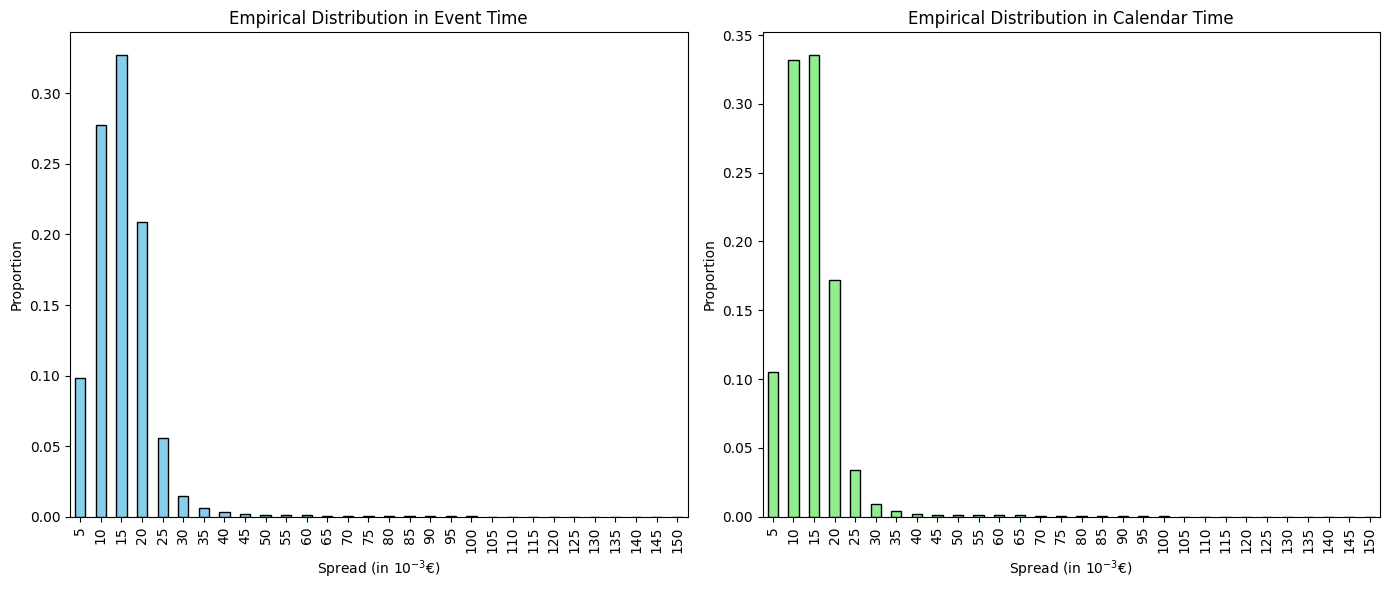

In [9]:
plot_spread_distribution(SG_df)

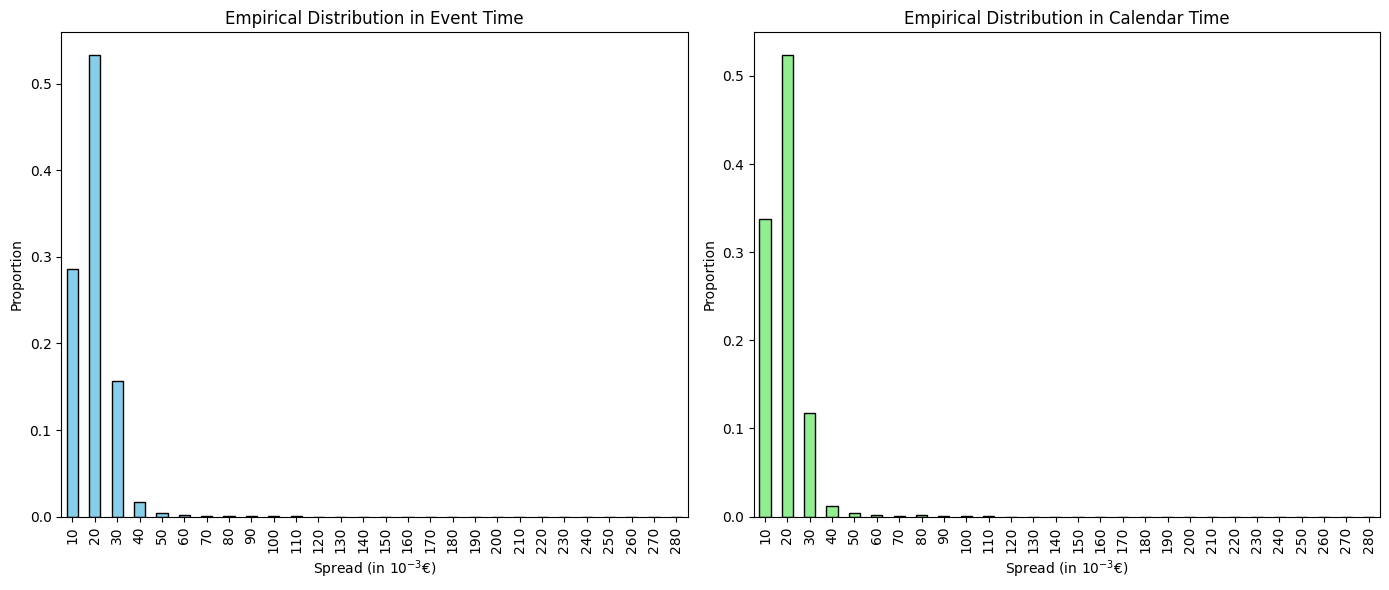

In [10]:
plot_spread_distribution(BNPP_df)

Comments: we see that the spread distribution is way more concentrated in 
BNPP stock, thus SG will be considered as our large tick and BNPP as our 
small tick. 

Now we can reproduce the result of the paper for our large and small tick 
stocks:
- $\epsilon$ is defined as the trade sign, we use our lab 1 code to compute 
according to the price impact
- $s$ is the trade side, we use the eside column

In [11]:
def compute_s(df_q6): # computes s the side
    df_q6["s"]=numpy.where((df_q6['eside'] == 'S'),-1,numpy.where(
    (df_q6['eside'] == 'B'),1,0))
    
def compute_epsilon(df_q6): # computes epsilon the sign
    df_q6['epsilon'] = numpy.where(
        (df_q6['eside'] == 'B') & (df_q6['etype'].isin(['A','M'])) 
        & (df_q6['eqty']> 0), 1,
        
        numpy.where(
        (df_q6['eside'] == 'B') & (df_q6['etype'].isin(['A','M'])) 
        & (df_q6['eqty']< 0), -1,
            
        numpy.where(
        (df_q6['eside'] == 'B') & (df_q6['etype'].isin(['T','C'])) 
        & (df_q6['eqty'] > 0), -1,
            
        ## reciprocally for sells    
        numpy.where(
        (df_q6['eside'] == 'S') & (df_q6['etype'].isin(['A','M'])) 
        & (df_q6['eqty']> 0), -1,
        
        numpy.where(
        (df_q6['eside'] == 'S') & (df_q6['etype'].isin(['A','M'])) 
        & (df_q6['eqty']< 0), +1,
            
        numpy.where(
        (df_q6['eside'] == 'S') & (df_q6['etype'].isin(['T','C'])) 
        & (df_q6['eqty']> 0), +1,
        
        0))))))

In [12]:
## we add our signs and sides
compute_s(SG_df); compute_epsilon(SG_df)
compute_s(BNPP_df); compute_epsilon(BNPP_df)


In [13]:
def plot_autocorrelation_logscale(time_series, legend='ACF', max_lag=10000):
    x = time_series.copy()
    lags = numpy.logspace(0, numpy.log10(max_lag), 50, dtype=int)
    autocorrelation = [x.corr(x.shift(-lag)) for lag in lags]
    plt.loglog(lags, autocorrelation, marker='x', linestyle='--', 
               label=legend)

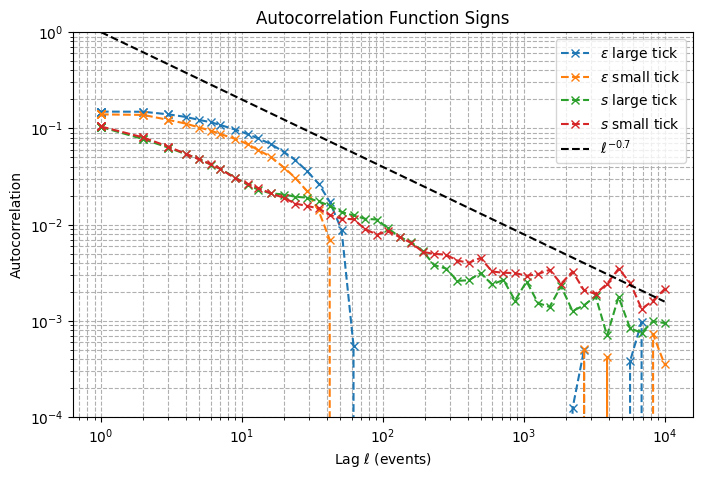

In [14]:
plt.figure(figsize=(8, 5))

## eps large puis small
plot_autocorrelation_logscale(SG_df['epsilon'],
                              "$\epsilon$ large tick")
plot_autocorrelation_logscale(BNPP_df['epsilon'],
                              "$\epsilon$ small tick")

## s large puis small
plot_autocorrelation_logscale(SG_df['s'],
                              "$s$ large tick")
plot_autocorrelation_logscale(BNPP_df['s'],
                              "$s$ small tick")

max_lag=10000
lags = numpy.logspace(0, numpy.log10(max_lag), 50, dtype=int)
# Add power-law reference line
plt.loglog(lags, lags**-0.7, 'k--', label=r'$\ell^{-0.7}$')

plt.xlabel(r'Lag $\ell$ (events)')
plt.ylabel('Autocorrelation')
plt.title("Autocorrelation Function Signs")
plt.ylim((1e-4, 1e0))
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

##### Question 2 :  Compute and plot the empirical response functions $R\pi
 (l)$ for each of the 6 types of events $\pi$.

In [15]:
def add_best_volume(df):
    df['best_volume'] = np.where(df['eside']=='B',df['bq0'].shift(1),
                        np.where(df['eside']=='S',df['aq0'].shift(1),0)) 
    
def get_pi_epsilon(lob_df):
    # --- Define conditions for each event type ---
    # Market orders
    cond_mo0 = (lob_df['etype'] == 'T') & (lob_df['eqty'] < 
                                           lob_df['best_volume'])
    cond_mop = (lob_df['etype'] == 'T') & (lob_df['eqty'] >= 
                                           lob_df['best_volume'])
    
    # Cancellations
    cond_ca0 = (lob_df['etype'] == 'C') & (lob_df['eqty'] < 
                                           lob_df['best_volume'])
    cond_cap = (lob_df['etype'] == 'C') & (lob_df['eqty'] >= 
                                           lob_df['best_volume'])
    cond_partial_cap = (lob_df['etype'] == 'M') & (lob_df['eqty'] < 0)
    
    # Limit orders
    cond_lo0_S = ((lob_df['etype'].isin(['A', 'M'])) & (lob_df['eqty'] >= 0) &
                  (lob_df['eside'] == 'S')& (lob_df['eprice'] == 
                                             lob_df['ap0'].shift(1)))
    
    cond_lo0_B = ((lob_df['etype'].isin(['A', 'M'])) & (lob_df['eqty'] >= 0) &
                  (lob_df['eside'] == 'B') & (lob_df['eprice'] == 
                                              lob_df['bp0'].shift(1)))
    
    cond_lop = ((lob_df['etype'].isin(['A', 'M'])) & (lob_df['eqty'] >= 0) & 
                ((lob_df['eprice'] > lob_df['bp0'].shift(1)) & 
                 (lob_df['eprice'] < lob_df['ap0'].shift(1))))
    
    # --- Create the 'pi' column using np.select ---
    conditions = [cond_mo0, cond_mop, 
                  cond_ca0, cond_cap, cond_partial_cap,
                  cond_lo0_B,cond_lo0_S, cond_lop]
    choices = ['MO0', "MO'", 
               'CA0', "CA'", 'CA0', 
               'LO0','LO0', "LO'"]
    lob_df['pi'] = np.select(conditions, choices, default='')

    # --- Define effective sign (epsilon_pi) based on event type and side ---
    pos_list = ['MO0', "MO'", 'LO0', "LO'"]
    neg_list = ['CA0', "CA'"]
    
    lob_df['epsilon_pi'] = np.where(
        (lob_df['pi'].isin(pos_list)) & (lob_df['eside'] == 'B'),
        1,
        np.where(
            (lob_df['pi'].isin(pos_list)) & (lob_df['eside'] == 'S'),
            -1,
        np.where(
            (lob_df['pi'].isin(neg_list)) & (lob_df['eside'] == 'S'),
            1,
        np.where(
            (lob_df['pi'].isin(neg_list)) & (lob_df['eside'] == 'B'),
            -1,
        0))))


In [16]:
add_best_volume(SG_df)
add_best_volume(BNPP_df)
# Apply the function and assign to a temporary DataFrame
get_pi_epsilon(SG_df)
get_pi_epsilon(BNPP_df)

In [17]:
SG_df[['pi']].value_counts()

pi 
CA0    2815329
       2653998
LO0    1247534
CA'     717149
LO'     205439
MO0     126029
MO'      61532
Name: count, dtype: int64

In [26]:
def compute_signed_event_correlation_logspace(df, pi1, pi2, n_points=50, max_lag=10000):
    ts1 = df['epsilon'] * np.where(df['pi'] == pi1,1,0)
    P1 = np.where(df['pi'] == pi1,1,0).mean()
    P2 = np.where(df['pi'] == pi2,1,0).mean()

    lags = np.unique(np.logspace(0, np.log10(max_lag), n_points).astype(int))
    corr_values = []

    for lag in lags:
        ts2 = df['epsilon'].shift(-lag) * np.where(df['pi'].shift(-lag) == 
                                                      pi2,1,0)
        prod = ts1 * ts2
        C = prod.mean() / (P1 * P2) if P1 > 0 and P2 > 0 else np.nan
        corr_values.append(C)

    return lags, np.array(corr_values)

def plot_signed_correlation(lags, corr_values,ax, label=''):    
    ax.plot(lags, corr_values, marker='o', linestyle='-', label=label)    

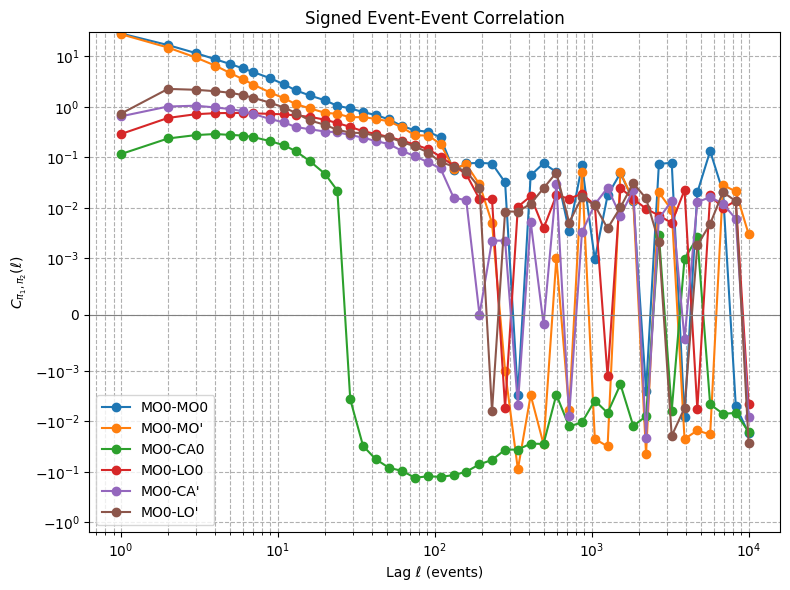

In [27]:
# Example usage after computing your DataFrame `df`
fig, ax = plt.subplots(figsize=(8, 6))

### on reproduit les resultats du papier juste pour SG car pas de différence 
# entre large et small tick selon les auteurs
lags, corr_values = compute_signed_event_correlation_logspace(SG_df, pi1='MO0',pi2='MO0')
plot_signed_correlation(lags, corr_values, ax, label='MO0-MO0')

lags, corr_values = compute_signed_event_correlation_logspace(SG_df, pi1='MO0',pi2='MO\'')
plot_signed_correlation(lags, corr_values, ax, label='MO0-MO\'')

lags, corr_values = compute_signed_event_correlation_logspace(SG_df, 
                                                              pi1='MO0',
                                                              pi2='CA0')
plot_signed_correlation(lags, corr_values, ax, label='MO0-CA0')

lags, corr_values = compute_signed_event_correlation_logspace(SG_df, pi1='MO0',
                                                              pi2='LO0')
plot_signed_correlation(lags, corr_values, ax, label='MO0-LO0')

lags, corr_values = compute_signed_event_correlation_logspace(SG_df, pi1='MO0',
                                                              pi2='CA\'')
plot_signed_correlation(lags, corr_values, ax, label='MO0-CA\'')

lags, corr_values = compute_signed_event_correlation_logspace(SG_df, pi1='MO0',
                                                              pi2='LO\'')
plot_signed_correlation(lags, corr_values, ax, label='MO0-LO\'')


ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1e-3)  

ax.axhline(0, color='gray', linewidth=0.8)
ax.set_xlabel("Lag ℓ (events)")
ax.set_ylabel(r"$C_{\pi_1,\pi_2}(\ell)$")
ax.set_title("Signed Event-Event Correlation")
ax.grid(True, which='both', ls='--')
ax.legend()
plt.tight_layout()
plt.show()

In [28]:
## now we consider the market impact
## we use midprice as a starter
def add_midprice(df):
    df['mid_price'] = (df['bp0'] + df['ap0']) / 2
    df.dropna(inplace=True)
    return df

In [21]:
add_midprice(SG_df)
add_midprice(BNPP_df)

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,weighted_mid_price,spread,s,epsilon,best_volume,pi,epsilon_pi
1,2017-01-17 09:01:00.727609,A,61150,16,S,61010,149,61080,108,61045.0,61039.416342,70,-1,-1,200.0,,0
2,2017-01-17 09:01:00.748616,C,61190,151,S,61010,149,61080,108,61045.0,61039.416342,70,-1,1,108.0,CA',1
3,2017-01-17 09:01:00.748622,C,61180,302,S,61010,149,61080,108,61045.0,61039.416342,70,-1,1,108.0,CA',1
4,2017-01-17 09:01:00.774298,A,61240,302,S,61010,149,61080,108,61045.0,61039.416342,70,-1,-1,108.0,,0
5,2017-01-17 09:01:01.566238,A,61010,93,B,61010,242,61080,108,61045.0,61031.600000,70,1,1,149.0,LO0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5423825,2017-02-01 17:29:59.720330,C,60540,200,B,60540,981,60560,208,60550.0,60543.498738,20,1,-1,1181.0,CA0,-1
5423826,2017-02-01 17:29:59.748966,M,59300,0,B,60540,981,60560,208,60550.0,60543.498738,20,1,0,981.0,,0
5423827,2017-02-01 17:29:59.803707,M,60410,0,B,60540,981,60560,208,60550.0,60543.498738,20,1,0,981.0,,0
5423828,2017-02-01 17:29:59.993852,C,60540,78,B,60540,903,60560,208,60550.0,60543.744374,20,1,-1,981.0,CA0,-1


In [32]:
## now lets compute the market impact on mid price
def compute_response_function(df, pi, n_points=50, max_lag=10000):
    lags = np.unique(np.logspace(0, np.log10(max_lag), n_points).astype(int))
    corr_values = []
    t = compute_tick_size(df)
    ts2 = np.where((df['pi'] == pi),df['epsilon'],0)
    for lag in lags:
        price_diff = df['mid_price'].shift(-lag) - df['mid_price']    
        prod = price_diff * ts2
        R_lag = prod.mean()
        
        corr_values.append(R_lag/t)

    return lags, np.array(corr_values)

def plot_response(lags, corr_values,ax, label=''):    
    ax.plot(lags, corr_values, marker='o', linestyle='-', label=label)    

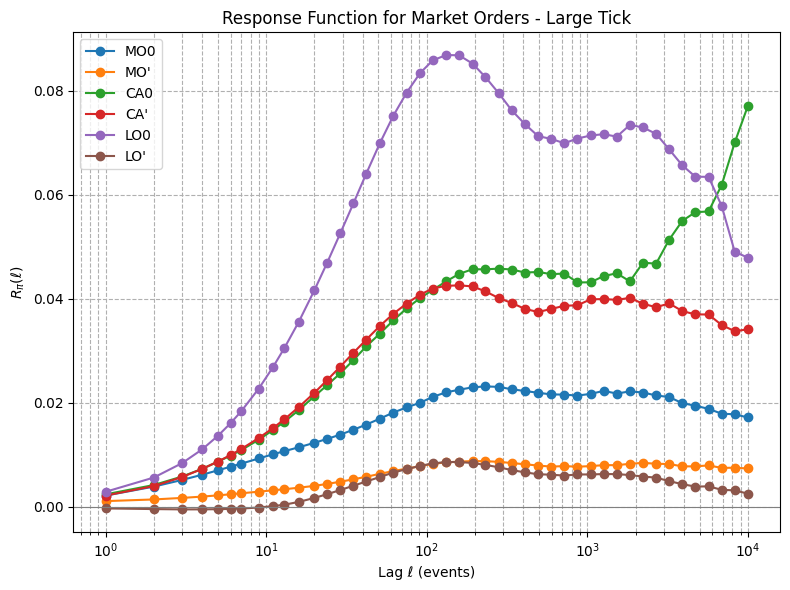

In [33]:
# Let us plot the response functions
filtered_df = SG_df.copy()

fig, ax = plt.subplots(figsize=(8, 6))
## on reproduit les resultats du papier juste pour SG car pas de différence
# entre large et small tick selon les auteurs
lags, corr_values = compute_response_function(filtered_df, pi='MO0')
plot_response(lags, corr_values, ax, label='MO0')
lags, corr_values = compute_response_function(filtered_df, pi='MO\'')
plot_response(lags, corr_values, ax, label='MO\'')

lags, corr_values = compute_response_function(filtered_df, pi='CA0')
plot_response(lags, corr_values, ax, label='CA0')
lags, corr_values = compute_response_function(filtered_df, pi='CA\'')
plot_response(lags, corr_values, ax, label='CA\'')

lags, corr_values = compute_response_function(filtered_df, pi='LO0')
plot_response(lags, corr_values, ax, label='LO0')
lags, corr_values = compute_response_function(filtered_df, pi='LO\'')
plot_response(lags, corr_values, ax, label='LO\'')

ax.set_xscale('log')

ax.axhline(0, color='gray', linewidth=0.8)
ax.set_xlabel("Lag ℓ (events)")
ax.set_ylabel(r"$R_{\pi}(\ell)$")
ax.set_title("Response Function for Market Orders - Large Tick")
ax.grid(True, which='both', ls='--')
ax.legend()
plt.tight_layout()
plt.show()

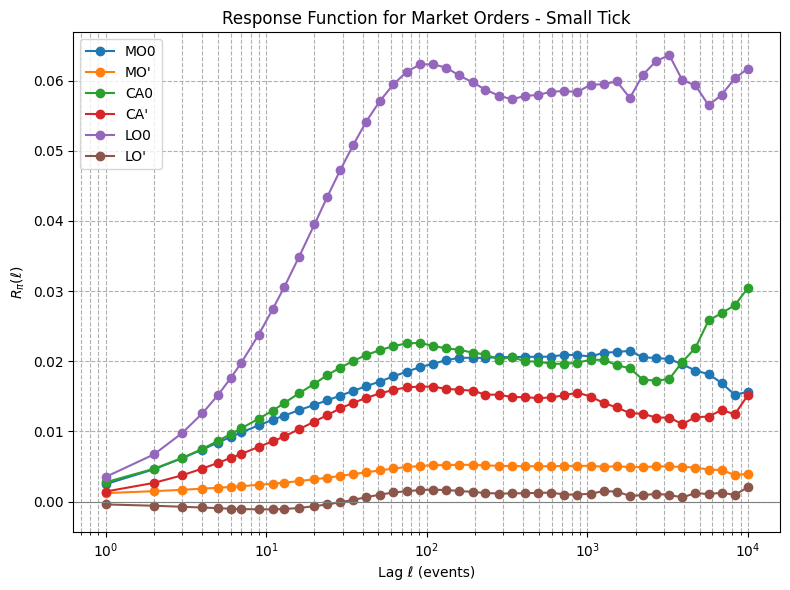

In [34]:
# Let us plot the response functions
filtered_df = BNPP_df.copy()

fig, ax = plt.subplots(figsize=(8, 6))
## on reproduit les resultats du papier juste pour SG car pas de différence
# entre large et small tick selon les auteurs
lags, corr_values = compute_response_function(filtered_df, pi='MO0')
plot_response(lags, corr_values, ax, label='MO0')
lags, corr_values = compute_response_function(filtered_df, pi='MO\'')
plot_response(lags, corr_values, ax, label='MO\'')

lags, corr_values = compute_response_function(filtered_df, pi='CA0')
plot_response(lags, corr_values, ax, label='CA0')
lags, corr_values = compute_response_function(filtered_df, pi='CA\'')
plot_response(lags, corr_values, ax, label='CA\'')

lags, corr_values = compute_response_function(filtered_df, pi='LO0')
plot_response(lags, corr_values, ax, label='LO0')
lags, corr_values = compute_response_function(filtered_df, pi='LO\'')
plot_response(lags, corr_values, ax, label='LO\'')


ax.set_xscale('log')

ax.axhline(0, color='gray', linewidth=0.8)
ax.set_xlabel("Lag ℓ (events)")
ax.set_ylabel(r"$R_{\pi}(\ell)$")
ax.set_title("Response Function for Market Orders - Small Tick")
ax.grid(True, which='both', ls='--')
ax.legend()
plt.tight_layout()
plt.show()